Note: if you are running this locally, make sure you have cloned the repo with ```git clone https://github.com/nyu-dl/DS-GA-1003-Machine-Learning-2025```.

Now, onto the magical journey!

# MessMaster: the Curse of the Muffin-Faced Dog (part 1)

<div>
<img src="media/entropy_comics.png" width="400"/>
</div>

If your room ever gets messy, you can blame the second law of thermodynamics because the room's entropy is always increasing.
No matter how much you try to tidy it up, the room will always get messy again.

An inventor named Boltzmann has a similar problem. He invented an **AutoSorter 3025** to sort similar objects into different bins.
However, there is a room that the AutoSorter does not work well.
It is a room full of chihuahuas and blueberry muffins.

<div>
<img src="media/chihuahua_muffin.png" width="400"/>
</div>

The auto-sorter cannot tell them apart because this is what it sees:

<div>
<img src="media/chihuahua_muffin_embedding.png" width="400"/>
</div>

Each object is reduced to just two features:

1. How likely there are two large black dots (potentially eyes).
2. How likely there is a brown circular shape (muffin top or Chihuahua fur).

Unfortunately, these features don't fully capture the difference between a muffin and a tiny, confused dog—leading to some interesting classification errors...

In his desperation, Boltzmann uncovered a dusty copy of 'Machine Learning: A Lecture Note,' rumored to be written by a wise scholar known only as 'The Guardian of Patterns.' Now, Boltzmann needs help, and that’s where you come in. As apprenticies of the Guardian of Patterns, your mission is to train a better classifier and fix the AutoSorter 3025.

- Understand how the energy function related to classification
- Compare and contrast zero-one loss, margin loss, and cross-entropy loss to see how different training objectives affect learning.
- Observe how the decision boundary evolves as we train a Perceptron, SVM, and Logistic Regression classifier.

By mastering these principles, you will help Boltzmann restore order to the Muffin-Chihuahua crisis—before entropy wins again!

Feedback:
- Maybe ask students to do some ahead of time or skip some questions
- Half an hour without questions

---
### 1. Energy Function and Classification

First, Boltzmann wants you to prove you are an apprentice of the Guardian of Patterns. He has seen 'energy function' in the book, and he wants you to explain it in the context of his chihuahua and muffin dilemma.

> An energy function $e$ assigns a real value to an observed instance and a latent instance $(x,z)$ and is parameterized by a multi-dimensional vector $\theta$.

> $$e: \mathcal{X}\times\mathcal{Z}\times\mathcal{\Theta}\mapsto\mathbb{R}.$$

**Q1a**. What does the energy function do in the context of classifying chihuahuas (positive) and muffins (negative)?

Answer: It assigns a score to a paired instance of ambiguous object (round brown circle with two large black dots), the predicted object type (either chihuahua or muffin), and the parameters. We should design the energy function such that the score is low when the prediction matches the true object type. For example, if the object is a muffin, the energy should be low when the prediction is muffin and high when the prediction is chihuahua. Vice versa for chihuahua.

**Q1b**. Given some examples of what $x,z,\theta$ are in the context of chihuahuas v.s. muffins from AutoSorter 3025's perspective.

Answer: 
- Observed instance $x$: large black dots (potentially eyes) and brown circular shape (muffin top or Chihuahua fur)
- Latent instance $z$: presence of ears, presence of tail, ability to bark
- Parameter $\theta$: weights of the features

AutoSorter 3025 cannot tell the difference because its choice of features is not good. We are going to use better features so that they are somewhat separable in the feature space.

For now we will assume there is no latent variable and that observed instance comes in pairs $(x,y)$, where $x$ is the feature and $y$ is the label. 

So the energy function is 
$e: (\mathcal{X}\times\mathcal{Y}) \times \emptyset \times \Theta \mapsto \mathbb{R}$.

**Q1c.** Given a new observation $x'$, how do you infer if it's Chihuahua or muffin ($y'$) based on your energy function?

Answer: $$y'=\argmin_{y\in\mathcal{Y}} e((x',y),\emptyset,\theta).$$

**Q1d**. How do we learn the parameters $\theta'$?

By minimizing the expected energy over the observed data. 
$$\theta' = \argmin_{\theta\in\Theta} \mathbb{E}_{(x,y)\sim D} [ e((x,y),\emptyset,\theta)].$$

---


### 2. Optimizing Parameters: from Energy to Loss and Probabilities

"Thanks for explaining energy function to me!" Boltzmann says. "Now I want to learn the parameters $\theta$ for my energy function, but I have a few more questions."

**Q2a.** 
> $$\hat{y}(x) = \argmin_{y} e((x,y),\emptyset,\theta).$$
The inference of label involves a for loop and seems to be slow. How can we parallelize it?

Answer:

We can think of a look-up table to store the energy of each label conditioned on the input. This way, we can pre-compute the embedding of $x$, and look up in parallel. 

$$e((x,y),\emptyset,\theta) = \mathbb{1}(y)^T f(x,\theta),$$

where $\mathbb{1}$ is a one-hot vector and $f: \mathcal{X}\times\Theta \mapsto \mathbb{R}^{|\mathcal{Y}|}$ is the feature extractor.




Boltzmann said, "I'll start with a simple feature extractor. Let's say it's linear. So $f(x,\theta) = Wx + b$." How I learn the parameters for $f$?

You learned the simplest way is using zero-one loss. That is, trying to update $\theta$ whenever the lowest-energy label is not the true label.

However, this objective is not differentiable, so it's hard to optimize. So we use other loss functions such as margin loss and cross-entropy loss.

**Q2b.** What is margin loss?


Answer: 

Margin loss is a "soft" proxy of zero-one loss that is easier to optimize. The goal is to make the energy associated with the true outcome lower (by some margin $m$) than the energy associated with any other outcome. 

$$
e((x,y'),\emptyset,\theta) - e((x,y),\emptyset,\theta) \geq m, \forall y'\neq y.$$

Rearranging the inequality, we get

$$m  + e((x,y),\emptyset,\theta) - e((x,y'),\emptyset,\theta) \leq 0, \forall y'\neq y.$$

We want to penalize when the margin is violated. So the loss function is

$$L_{\text{margin}}((x,y),\theta) = \max(0,m+e((x,y),\emptyset,\theta)-e((x,\hat{y'}),\emptyset,\theta)),$$

where $\hat{y'}$ is the non-true label with the lowest energy. i.e., $\hat{y'} = \argmin_{y'\neq y} e((x,y'),\emptyset,\theta)$.

It is also called hinge loss because of the "hinge" shape of the loss function with linear feature extractor. (The y value is zero until the margin is violated, then it increases linearly.)

**Q2c.** What happens if we set the margin to 0?

Answer:

When the margin is set to 0, the loss function is called perceptron loss. With this loss function, we only update the parameters when the label is incorrectly classified. This is because given correct prediction, it must be the label with the lowest energy. And without the margin requirement, the inequality is already satisfied.


Boltzmann heard that cross-entropy loss is the most popular. But it is related to probabilities. He is confused about the connection and how this loss function reduces energy for the correct outcome.

**Q2d**. Help Boltzmann understand cross-entropy loss.

i. On a high level, how do we connect the energy function to categorical probabilities?

ii. Write down its definition.

iii. Derive its gradient with respect to $\theta$.

iv. What does the gradient tell us about the update rule?


Answer:

i. We derive it using constrained optimization. The objective comes from the principles of maximum entropy and the stability of low energy states. The constraints come from definition of probabilities.

Specifically we maximize $-\sum p_i \log p_i - \beta\sum p_i a_i = H(p) - \mathbb{E}_p[a_i] $, where $a_i$ is the energy of the $i$-th outcome ($a_i = e((x,y_i),\emptyset,\theta)$). The constraints are $\sum p_i = 1$ (normalization) and $p_i \geq 0$ (non-negativity). The $\beta$ is the inverse temperature, where the default value is 1.

We can solve this using Lagrange multiplier. The solution is the softmax function.

$$p_i = \frac{\exp(-a_i)}{\sum_{j} \exp(-a_j)}.$$

ii. The loss function (or the negative log-likelihood) is

$$L_{\text{cross-entropy}}((x,y),\theta) = -\log p_y = a_y + \log \sum_{y'\in\mathcal{Y}} \exp(-a_{y'}).$$

iii. The gradient is

$$\nabla_{\theta} L_{\text{ce}} = \nabla_{\theta} a_y + \nabla_{\theta} \log \sum_{y'\in\mathcal{Y}} \exp(-a_{y'}).$$

$$\nabla_{\theta} L_{\text{ce}} = \nabla_{\theta} a_y + \frac{ -\sum_{y''\in\mathcal{Y}} \exp(-a_{y''})\nabla a_{y''}}{\sum_{y'\in\mathcal{Y} }\exp(-a_{y'})}$$

$$\nabla_{\theta} L_{\text{ce}} = \nabla_{\theta} e((x,y),\emptyset,\theta) - \mathbb{E}_{y'\sim p(y'|x,\theta)} \nabla_{\theta} e((x,y'),\emptyset,\theta).$$

Since we are minimizing the negative log-likelihood, the update is in the direction of the negative gradient. Let $\eta >0$ be the learning rate, the parameter update is

$$\Delta \theta = -\eta \nabla_{\theta} e((x,y),\emptyset,\theta) + \eta \mathbb{E}_{y'\sim p(y'|x,\theta)} \nabla_{\theta} e((x,y'),\emptyset,\theta).$$

iv. 
- The first part of the gradient shows that we update parameters such that true outcomes have low energy. If a parameter increases the true label's energy ($a_y > 0$), it would have a negative update. 
- The second part shows that we update parameters such that incorrect outcomes have high energy. If a parameter increases the expected energy of all labels ($\mathbb{E}[a_{y'}] > 0$), it would have a positive update.




---

### 3. The Subtle Boundary of Chihuahua and Muffin: Classification in Action

<div>
<img src="media/chihuahua_room.png" width="400"/>
</div>

You step into the room filled with chihuahuas and muffins. You will use three kinds of loss function to reduce the energy assigned to chihuahua and increase the energy assigned to muffin. You are determined to fix Boltzmann's AutoSorter 3025.

First, we will write a plotting function to visualize the training process. 

Exercise: 
Read the code and try to connect it with the mathematical concepts we discussed. Write comments to connect the mathematical concepts to the code. Where is:

- energy function $e$
- observed data $x$
- learnable parameter $\theta$
- learned parameter $\theta'$
- loss function $L$
- the inferenced label $\hat{y}(x)$?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
def plot_training_evolution(X, y, model, iterations=10, batch_size=1, title="Model Evolution"):
    """
    Plot decision boundary evolution over training, showing only seen data at each iteration.

    Args:
        X (ndarray): Input features.
        y (ndarray): Labels.
        model: The model (Perceptron, Logistic Regression, or SVM). # NOTE: model contains the learnable parameter
        iterations (int): Number of iterations to train.
        batch_size (int): Number of examples seen in each iteration.
        title (str): Plot title.
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10, 4.5))

    num_samples = X.shape[0]
    for i in range(iterations):
        # Select a subset of the data (seen data)
        start_idx = (i * batch_size) % num_samples
        end_idx = start_idx + batch_size
        X_seen = X[start_idx:end_idx] # NOTE: this is the observed data x
        y_seen = y[start_idx:end_idx]

        # Train the model on the seen data
        # Exercise: replace this line with manual_partial_fit(model, X_seen, y_seen, classes)
        # You need to implement the following steps:
        # 1. compute model prediction
        # 2. compute error
        # 3. compute parameter update
        # 4. update model parameters
        # NOTE: within the learning, the loss function is used to update the parameter. 
        # Minimizing the loss function is equivalent to minimizing the energy function.
        model.partial_fit(X_seen, y_seen, classes=np.unique(y))
        # NOTE: after fitting, this is the learned parameter

        # Compute the decision boundary
        if hasattr(model, "decision_function"):
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary and seen data
        plt.subplot(2, 5, i + 1)
        plt.contourf(xx, yy, Z > 0, alpha=0.8, cmap="coolwarm") # NOTE: Z > 0 is the label
        X_new = X[start_idx:end_idx]
        y_new = y[start_idx:end_idx]
        X_old = X[:start_idx]
        y_old = y[:start_idx]
        norm = Normalize(vmin=0, vmax=1)
        if len(X_old) > 0:
            plt.scatter(X_old[:, 0], X_old[:, 1], c=y_old, edgecolor="k", cmap=plt.cm.viridis, label="Previous Data", norm=norm)
        plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, edgecolor="red", cmap=plt.cm.viridis, label="New Data", norm=norm)
        plt.title(f"{title} Iteration {i + 1}")
        plt.xlabel("Likely Ear")
        plt.ylabel("Likely Leg")

    # add legend
    plt.tight_layout()
    plt.show()

Next, we will load the generated data and standardize it.

In [2]:
%pip install pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("data/margin_classifier_alternate.csv")
X = df[["x1", "x2"]].values
y = df["y"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_2 = pd.read_csv("data/svm_vs_logistic_regression.csv")
X_2 = df_2[["x1", "x2"]].values
y_2 = df_2["y"].values
X_2_scaled = scaler.transform(X_2)

/Users/lavender/Desktop/DS-GA-1003-Machine-Learning-2025/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


Finally, we will define the training functions for the three models.

In [3]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier


def train_perceptron(X, y, iterations=10, class_weight=None, batch_size=1):
    perceptron = Perceptron(max_iter=1, tol=None, warm_start=True, random_state=42, class_weight=class_weight)
    plot_training_evolution(X, y, perceptron, iterations, batch_size, title="Perceptron")


def train_svm(X, y, iterations=10, margin=3, batch_size=1):
    assert margin > 0, "Margin must be positive. If margin is 0, it becomes a ???." # TODO: fill in the ???
    alpha = 1 / (margin **2)
    svm = SGDClassifier(loss="hinge", max_iter=1, tol=None, alpha=alpha, warm_start=True, random_state=42)
    plot_training_evolution(X, y, svm, iterations, batch_size, title="SVM")


def train_logistic_regression(X, y, iterations=10, batch_size=1):
    logistic = SGDClassifier(loss="log_loss", max_iter=1, alpha=0.01, tol=None, warm_start=True, random_state=42)
    plot_training_evolution(X, y, logistic, iterations, batch_size, title="LogReg")

**Q3a. Perceptron v.s. SVM**

Let's first start classifying using two models with similar loss functions. Observe the training process of Perceptron and SVM.

i. How does the decision boundary change? 

ii. What is the difference between the final decision boundary of the two models? 

iii. What causes this difference?

iv. (Exercise) What happens if you increase or decrease the margin for SVM? Why does this happen?

Answer:

i. The decision boundary updates sequentially. It changes if a point if misclassified for perceptron, or if a point's margin is violated for SVM.

ii. The final decision boundary of SVM has a larger margin than perceptron.

iii. SVM has a positive margin.

iv. The distance between the decision boundary and the data points becomes larger if we increase the margin and vice versa. 

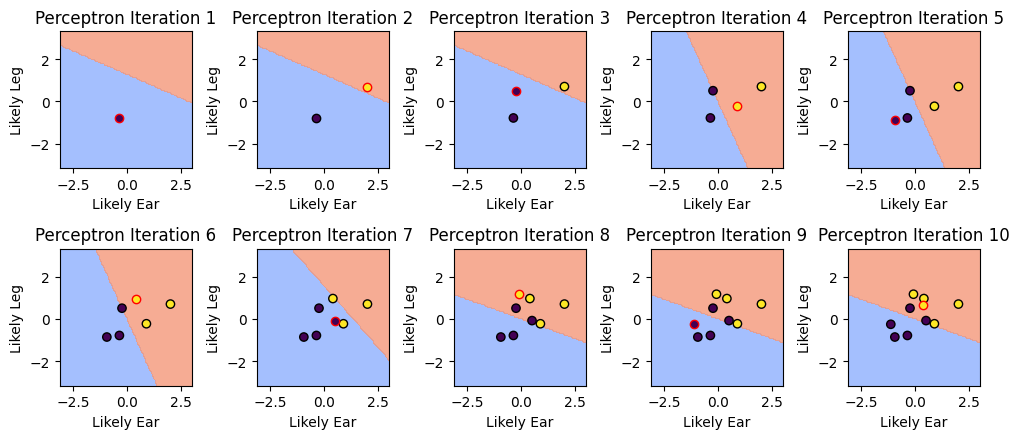

In [4]:
train_perceptron(X_scaled, y, iterations=10) #, class_weight="balanced")#{0: 1, 1: 0})


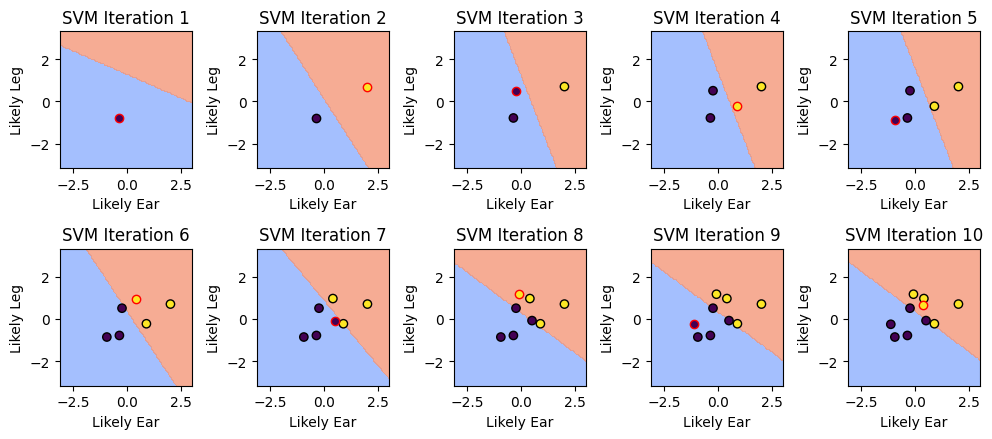

In [5]:
train_svm(X_scaled, y, iterations=10, margin=3)


**Q3b. SVM v.s. Logistic Regression**

Next let's compare Max Margin Classifier (SVM) and Logistic Regression Classifier.

How does the changes in decision boundary differ between the two models? Why?

Answer:

The decision boundary of logistic regression is smoother than SVM. This is because it is maximizing the log-likelihood of the observed data. Whereas SVM is maximizing the margin and reducing the number of misclassified points.


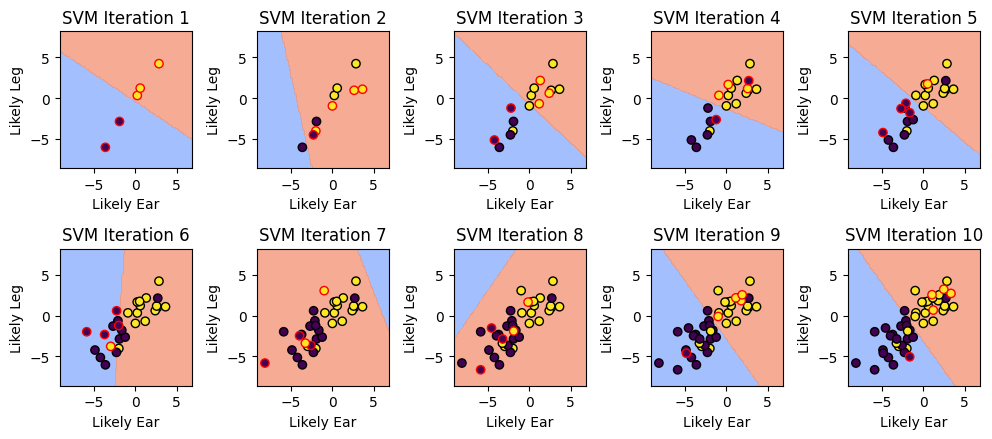

In [6]:
train_svm(X_2_scaled, y_2, iterations=10, margin=3, batch_size=5)

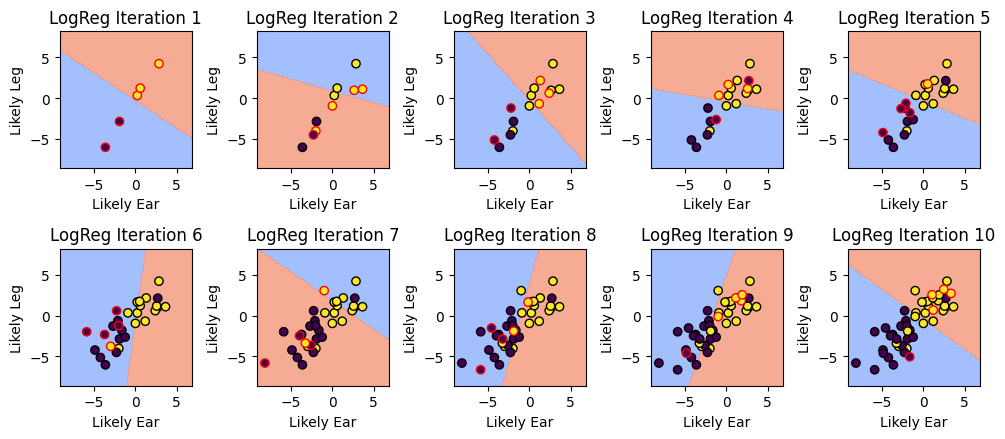

In [7]:
train_logistic_regression(X_2_scaled, y_2, iterations=10, batch_size=5)

So far, our decision boundary has been linear. Next time, we will see use MLP to learn a non-linear decision boundary.
This would enable us to better classify the chihuahua and muffin!

#### Supplementary: from minimizing energy to minimizing loss (logistic regression)

Let's start by defining the energy function

Since we are using linear model, a first thought is:

$s((x,y),\theta) = \mathbb{1}(y)^T f(x,\theta) = \mathbb{1}(y)^T (Wx + b)$

However, the feature extractor should not stop at $Wx + b$ because we need probabilities for classification. So we need to update the energy function to account for the probabilities.

As we have discussed, given $f$, using principles of maximum entropy and minimizing the expected energy, we can derive the probability of each label.

$\hat{p}(y|x,\theta) = \frac{\exp(-a_y)}{\sum_{y'\in\mathcal{Y}} \exp(-a_{y'})}$, where $a_y = \mathbb{1}(y)^T f(x,\theta)$.

So now let's go back to update our energy function. Again, we want lower energy for correct outcomes. A correct outcomes assigns high probability to the true label, or low negative log-likelihood to the true label. So we write the energy function as:

$e((x,y),\theta) = -\log p(y|x,\theta) = a_y - \log \sum_{y'\in\mathcal{Y}} \exp(-a_{y'}).$

And the minimization of expected energy becomes equivalent to minimizing the negative log-likelihood (cross-entropy loss).

$$\min_{\theta\in\Theta} \mathbb{E}_{(x,y)\in D} [e((x,y),\theta)] = \min_{\theta\in\Theta} \mathbb{E}_{(x,y)\in D} [-\log \hat{p}(y|x,\theta)] = \min_{\theta\in\Theta} \mathbb{E}_{(x,y)\in D}L_{\text{ce}}(((x,y),\theta).$$
